### 1. Importar librerías

Usar librerías para análisis y visualización de datos, y clustering.

In [1]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

# Clustering (K-Means) y pre procesamiento
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Operaciones con fechas
from datetime import datetime

### 2. Cargar y explorar los datos

- Carga el conjunto de datos en un DataFrame de Pandas.
- Explora el conjunto de datos calculando estadísticas clave (por ejemplo, número de clientes, ingresos totales).
- Gestiona los datos faltantes o inconsistentes.

#### 2.1 Cargar el conjunto de datos

In [3]:
# Cargar el archivo Excel 
df = pd.read_excel("./online-retail.xlsx") 

display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### 2.2 Explorar el conjunto de datos calculando estadísticas clave

**Estadísticas Clave para el Análisis de Clientes**

1. **Número de clientes únicos**:  
   Es relevante determinar la cantidad total de clientes distintos en el conjunto de datos, ya que este valor ofrece una visión sobre el tamaño real de la base de clientes. Con esta métrica se puede comprender el alcance del análisis y la segmentación.

2. **Ingresos totales (valor monetario)**:  
   Al calcular el producto de la cantidad (Quantity) y el precio unitario (UnitPrice) para cada transacción, y luego sumar estos valores, se obtienen los ingresos totales. Esta métrica sirve como referencia para entender el desempeño global del negocio y facilita la evaluación del aporte monetario de distintos segmentos de clientes.

3. **Ingreso promedio por cliente**:  
   Dividir los ingresos totales entre el número de clientes únicos permite obtener el gasto promedio por cliente. Esta medida es útil para comprender el valor del “cliente promedio” y detectar grupos de clientes que generen un gasto significativamente mayor o menor.

4. **Número de transacciones (frecuencia)**:  
   Contar el total de facturas (o InvoiceNo) aporta una idea de la actividad de compra general. Además, es posible calcular el promedio de transacciones por cliente, lo que se convierte en un indicador clave para el análisis de la dimensión de frecuencia dentro del modelo RFM.

5. **Ventana de recencia (recency)**:  
   Determinar la fecha más reciente y la más lejana de compra permite definir el periodo temporal del conjunto de datos. A partir de estas fechas, se puede calcular la recencia (por ejemplo, días desde la última compra) para cada cliente. Esta información resulta fundamental para comprender la “frescura” o la vigencia de la base de clientes y su actividad de compra.

In [4]:
# 1. Número de clientes únicos
num_clientes_unicos = df['CustomerID'].nunique()
print("Número de clientes únicos:", num_clientes_unicos)

# 2. Ingresos totales (Quantity * UnitPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
ingresos_totales = df['TotalPrice'].sum()
print("Ingresos totales:", ingresos_totales)

# 3. Ingreso promedio por cliente
if num_clientes_unicos > 0:
    ingreso_promedio_por_cliente = ingresos_totales / num_clientes_unicos
    print("Ingreso promedio por cliente:", ingreso_promedio_por_cliente)
else:
    print("No se encontraron clientes únicos, no es posible calcular el ingreso promedio por cliente.")

# 4. Número total de transacciones
num_transacciones = df['InvoiceNo'].nunique()
print("Número total de transacciones:", num_transacciones)

if num_clientes_unicos > 0:
    transacciones_promedio_por_cliente = num_transacciones / num_clientes_unicos
    print("Transacciones promedio por cliente:", transacciones_promedio_por_cliente)
else:
    print("No se encontraron clientes únicos, no es posible calcular las transacciones promedio por cliente.")

# 5. Ventana de recencia
# Convertir las fechas a formato datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

fecha_minima = df['InvoiceDate'].min()
fecha_maxima = df['InvoiceDate'].max()
print("Fecha mínima de compra:", fecha_minima)
print("Fecha máxima de compra:", fecha_maxima)

Número de clientes únicos: 4372
Ingresos totales: 9747747.933999998
Ingreso promedio por cliente: 2229.5855292772185
Número total de transacciones: 25900
Transacciones promedio por cliente: 5.924062214089662
Fecha mínima de compra: 2010-12-01 08:26:00
Fecha máxima de compra: 2011-12-09 12:50:00


**Análisis descriptivos y exploratorios adicionales**



**Distribución del gasto total por cliente**

Esta gráfica muestra cómo se reparte la inversión monetaria entre los distintos clientes. Analizar la distribución del gasto total (Monetary) es crucial para el análisis RFM, ya que nos permite comprender si existen clientes que gastan significativamente más que otros. Una alta concentración de gasto en pocos clientes podría indicar la presencia de un grupo "premium" que necesitará estrategias de retención distintas a la mayoría.


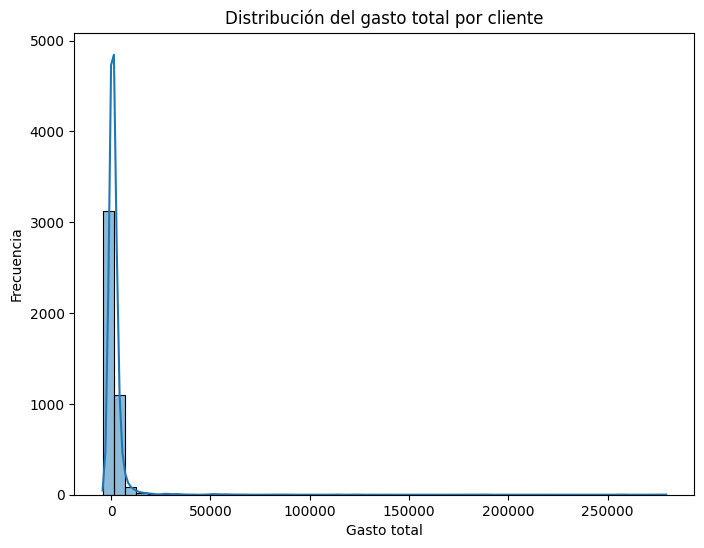

In [5]:
# Calcular el gasto total por cliente
gasto_por_cliente = df.groupby('CustomerID')['TotalPrice'].sum()

plt.figure(figsize=(8,6))
sns.histplot(gasto_por_cliente, bins=50, kde=True)
plt.title("Distribución del gasto total por cliente")
plt.xlabel("Gasto total")
plt.ylabel("Frecuencia")
plt.show()


**Distribución de la frecuencia de compra por cliente**

Esta gráfica muestra el número de transacciones (frecuencia) por cada cliente. Es relevante para identificar patrones en la regularidad de las compras. Si la mayoría de los clientes compra pocas veces, y algunos pocos compran muy frecuentemente, los segmentos de frecuencia pueden ayudar a diseñar estrategias específicas (por ejemplo, recompensas para clientes altamente frecuentes o campañas de reactivación para clientes de baja frecuencia).

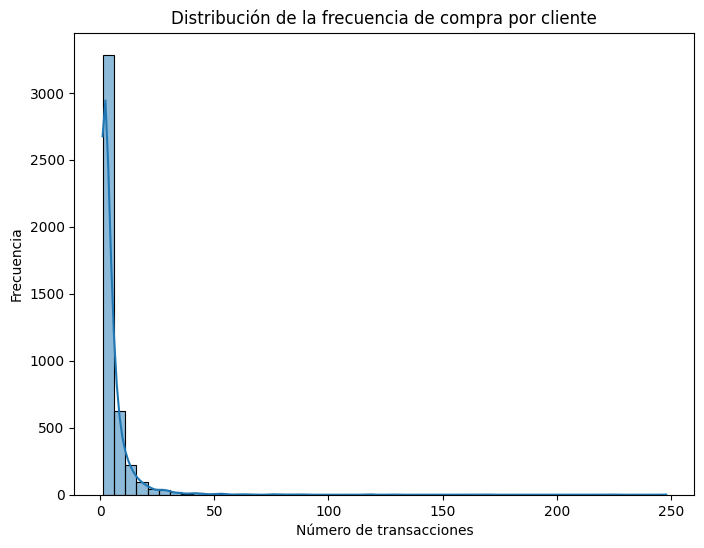

In [5]:
# Calcular la frecuencia de compra por cliente (número de facturas únicas por cliente)
frecuencia_por_cliente = df.groupby('CustomerID')['InvoiceNo'].nunique()

plt.figure(figsize=(8,6))
sns.histplot(frecuencia_por_cliente, bins=50, kde=True)
plt.title("Distribución de la frecuencia de compra por cliente")
plt.xlabel("Número de transacciones")
plt.ylabel("Frecuencia")
plt.show()

**Distribución de la recencia (días desde la última compra)**

La recencia se calcula normalmente tomando una fecha de referencia (como la última fecha disponible en el dataset) y midiendo cuántos días han pasado desde la última compra de cada cliente. Esta gráfica es fundamental para el RFM, ya que permite identificar qué tan activos se mantienen los clientes. Una alta concentración de valores altos de recencia implica muchos clientes inactivos, lo cual podría requerir campañas de retención o reactivación.


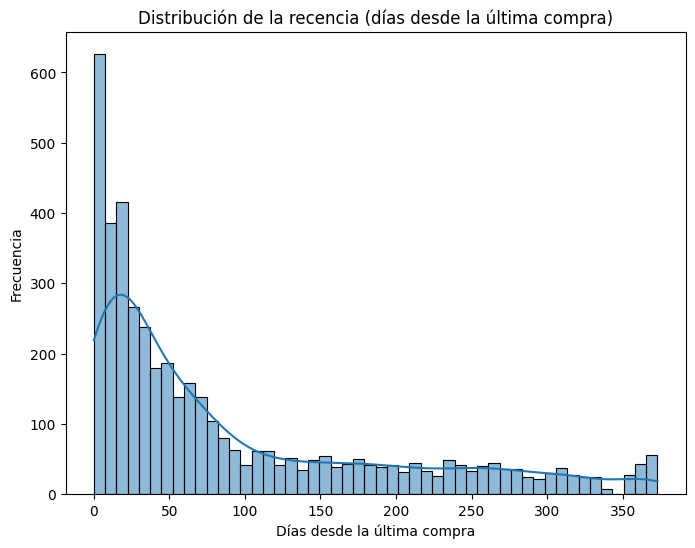

In [6]:
from datetime import timedelta

# Definir la fecha de referencia como la última fecha en el dataset
fecha_referencia = df['InvoiceDate'].max()

# Calcular la última fecha de compra por cliente
ultima_compra = df.groupby('CustomerID')['InvoiceDate'].max()

# Calcular la recencia en días
recencia = (fecha_referencia - ultima_compra).dt.days

plt.figure(figsize=(8,6))
sns.histplot(recencia, bins=50, kde=True)
plt.title("Distribución de la recencia (días desde la última compra)")
plt.xlabel("Días desde la última compra")
plt.ylabel("Frecuencia")
plt.show()


**Ingresos totales por país**

Este gráfico muestra los países con mayores ingresos totales. Aunque el análisis principal es a nivel de cliente, conocer el aporte por país nos ayuda a identificar mercados más fuertes. Esto puede ser relevante para entender la dinámica regional y focalizar estrategias de marketing. Por ejemplo, si un país genera la mayor parte de los ingresos, puede ser un objetivo principal para retención, mientras que en países con menos ingresos se podrían crear estrategias de penetración de mercado.

C:\Users\jmino\AppData\Local\Temp\ipykernel_55740\1608514853.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ingresos_por_pais.values, y=ingresos_por_pais.index, palette='viridis')


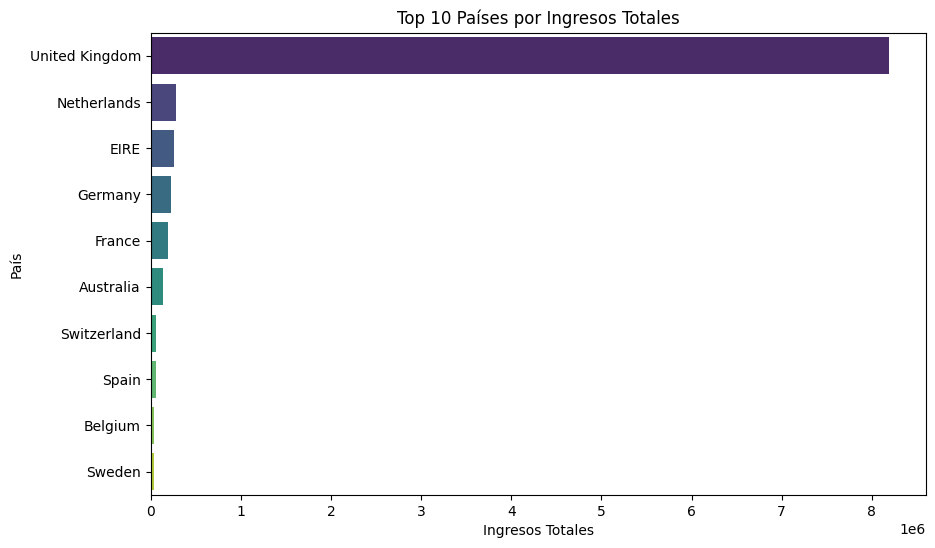

In [7]:
# Ingresos totales por país
ingresos_por_pais = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=ingresos_por_pais.values, y=ingresos_por_pais.index, palette='viridis')
plt.title("Top 10 Países por Ingresos Totales")
plt.xlabel("Ingresos Totales")
plt.ylabel("País")
plt.show()

**Mapa de calor de correlaciones**

Un mapa de calor de correlaciones entre las variables numéricas relevantes (por ejemplo, frecuencia, gasto total, recencia una vez calculada) ayuda a entender las relaciones entre estas dimensiones RFM. Esto orienta sobre qué variables tienen mayor interdependencia. Por ejemplo, si la frecuencia se relaciona fuertemente con el gasto total, podría indicar que clientes que compran con mayor regularidad también tienden a gastar más, lo cual es útil para la segmentación y las estrategias de marketing resultantes.

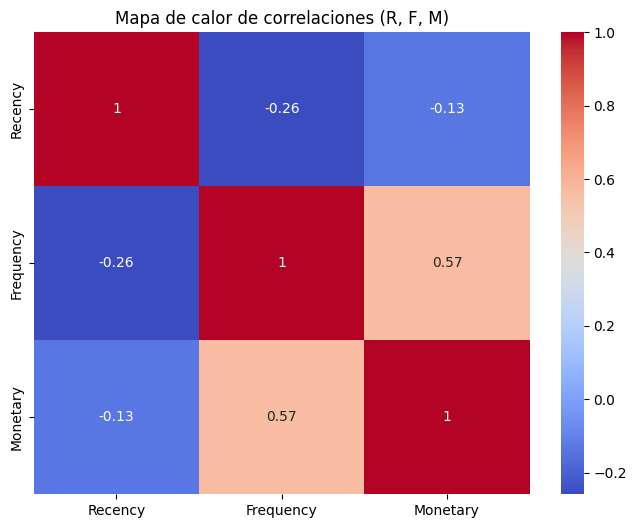

In [20]:
RFM = pd.DataFrame({
    'Recency': recencia,
    'Frequency': frecuencia_por_cliente,
    'Monetary': gasto_por_cliente
})

# Crear el mapa de calor de correlaciones
plt.figure(figsize=(8,6))
sns.heatmap(RFM.corr(), annot=True, cmap='coolwarm')
plt.title("Mapa de calor de correlaciones (R, F, M)")
plt.show()


**Conclusiones del análisis adicional**

**1. Distribución del gasto total por cliente**
- La mayoría de los clientes tiene un gasto total bajo, concentrado en los valores más pequeños del eje X.
- Existe una pequeña cantidad de clientes con un gasto significativamente más alto, lo que podría indicar la presencia de clientes "premium" o de alto valor.
- La asimetría positiva (cola larga) sugiere que el análisis de segmentación debe considerar escalas logarítmicas o técnicas para manejar datos sesgados hacia valores pequeños.

---

**2. Distribución de la frecuencia de compra por cliente**
- La mayor parte de los clientes realiza pocas transacciones, lo que implica que la frecuencia promedio de compra es baja.
- Una pequeña cantidad de clientes realiza compras repetitivas con mucha frecuencia, lo que podría representar un grupo de clientes altamente leales.
- Esta distribución refuerza la idea de que habrá segmentos bien diferenciados entre clientes frecuentes e infrecuentes, útiles para diseñar estrategias personalizadas.

---

**3. Distribución de la recencia (días desde la última compra)**
- Muchos clientes han realizado compras recientemente, lo que indica una base activa de clientes.
- Sin embargo, hay una disminución progresiva en la frecuencia conforme aumenta la recencia, lo que podría señalar que un segmento considerable de clientes está inactivo o necesita estrategias de reactivación.
- Clientes con recencia baja (cercanos al presente) son ideales para fidelización, mientras que los de recencia alta podrían requerir promociones para volver a comprar.

---

**4. Ingresos totales por país**
- El Reino Unido domina completamente los ingresos totales, lo que sugiere que es el mercado principal del negocio.
- Los demás países generan ingresos significativamente más bajos, lo que podría representar oportunidades de expansión o mercados secundarios que necesitan estrategias específicas.
- Este análisis ayuda a identificar prioridades regionales en las estrategias de marketing y segmentación.

---

**5. Mapa de calor de correlaciones (R, F, M)**
- Existe una correlación positiva moderada entre la frecuencia de compra y el gasto total, lo que sugiere que los clientes más frecuentes también tienden a gastar más.
- La recencia muestra una correlación negativa débil con las otras métricas (frecuencia y monetario), lo que indica que los clientes recientes no necesariamente gastan más o compran con mayor frecuencia.
- Estas correlaciones son útiles para validar el uso de RFM como base del análisis de segmentación, ya que muestran que las dimensiones tienen relaciones diferenciadas y aportan información complementaria.


#### 2.3 Gestionar datos faltantes o inconsistentes

In [6]:
original_rows = len(df)
print(f"Filas originales: {original_rows}")

# 1. Eliminar filas sin CustomerID
before_step = len(df)
df = df.dropna(subset=['CustomerID'])
after_step = len(df)
print(f"Filas eliminadas tras remover registros sin CustomerID: {before_step - after_step}")

# 2. Convertir a datetime y eliminar fechas inválidas
before_step = len(df)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df = df.dropna(subset=['InvoiceDate'])
after_step = len(df)
print(f"Filas eliminadas tras remover registros con fechas inválidas: {before_step - after_step}")

# 3. Eliminar filas con Quantity <= 0 o UnitPrice <= 0
before_step = len(df)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
after_step = len(df)
print(f"Filas eliminadas tras remover registros con Quantity/UnitPrice no válidos: {before_step - after_step}")

# 4. Eliminar duplicados
before_step = len(df)
df = df.drop_duplicates()
after_step = len(df)
print(f"Filas eliminadas tras remover duplicados: {before_step - after_step}")

# Filas totales eliminadas
final_rows = len(df)
print(f"Filas totales eliminadas: {original_rows - final_rows}")


Filas originales: 541909
Filas eliminadas tras remover registros sin CustomerID: 135080
Filas eliminadas tras remover registros con fechas inválidas: 0
Filas eliminadas tras remover registros con Quantity/UnitPrice no válidos: 8945
Filas eliminadas tras remover duplicados: 5192
Filas totales eliminadas: 149217


### 3. Ingeniería de características

Extrae características significativas como:

- Análisis RFM (Recencia, Frecuencia, Monetario):
    - Recencia: Días desde la última compra.
    - Frecuencia: Número total de compras.
    - Monetario: Gasto total.
- Normaliza estas características para asegurarte de que estén en una escala similar.

In [7]:
from sklearn.preprocessing import StandardScaler

# 1. Determinar la fecha de referencia
fecha_referencia = df['InvoiceDate'].max()

# 2. Calcular métricas RFM para cada cliente

# Recency (en días)
# Obtener la última fecha de compra por cliente
ultima_compra = df.groupby('CustomerID')['InvoiceDate'].max()
# Calcular la recencia
recency = (fecha_referencia - ultima_compra).dt.days

# Frequency (número total de compras)
# La frecuencia se puede calcular contando el número de facturas únicas por cliente
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Monetary (gasto total)
# El gasto total es la suma de TotalPrice por cliente
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
monetary = df.groupby('CustomerID')['TotalPrice'].sum()

# Combinar los tres en un DataFrame
RFM = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
})

display(RFM.head())

# 3. Normalización de los datos
# Utilizar StandardScaler para normalizar las métricas
scaler = StandardScaler()
RFM_scaled = scaler.fit_transform(RFM)

# Convertir el array escalado a DataFrame conservando los índices de los clientes
RFM_scaled_df = pd.DataFrame(RFM_scaled, index=RFM.index, columns=RFM.columns)

display(RFM_scaled_df.head())


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.334574,-0.425097,8.363010
12347.0,-0.905340,0.354417,0.251699
12348.0,-0.175360,-0.035340,-0.027988
12349.0,-0.735345,-0.425097,-0.032406
12350.0,2.174578,-0.425097,-0.190812


### 4. Implementar K-Means Clustering

- Utiliza el Método del Codo o la Puntuación de Silueta para determinar el número óptimo de clusters (k).
- Aplica el algoritmo K-Means utilizando el valor de k seleccionado.

#### 4.1 Utilizar el Método del Codo o la Puntuación de Silueta para determinar el número óptimo de clusters (k).

c:\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


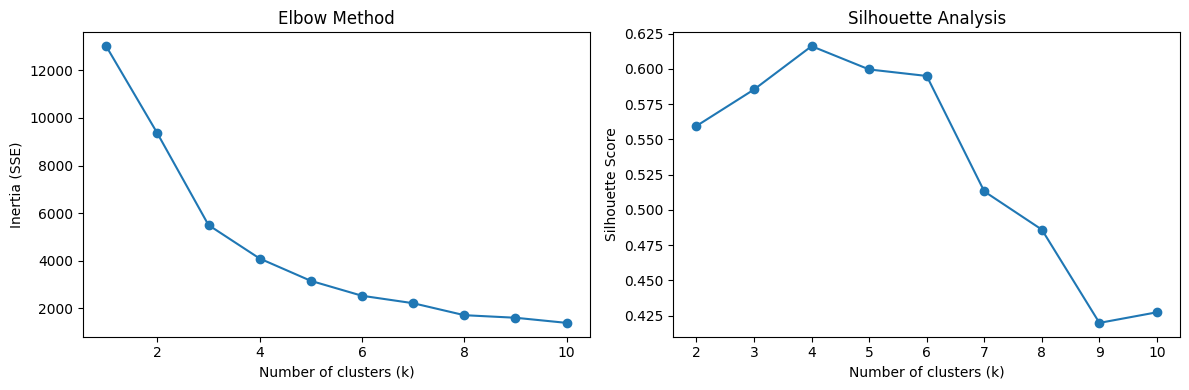

In [8]:
data_scaled = RFM_scaled_df.copy() 
data_scaled_values = data_scaled.values  # Extracting values for fitting

SSE = []  # Sum of Squared Errors (inertia)
ss = []   # Silhouette scores
test_clusters = 10

for cluster in range(1, test_clusters + 1):
    kmeans = KMeans(n_clusters=cluster, n_init="auto")
    kmeans.fit(data_scaled_values)
    SSE.append(kmeans.inertia_)
    labels = kmeans.predict(data_scaled_values)
    if cluster > 1:
        ss.append(silhouette_score(data_scaled_values, labels))

# Convert results into DataFrames for plotting
frame_in = pd.DataFrame({'Cluster': range(1, test_clusters + 1), 'SSE': SSE}) 
frame_ss = pd.DataFrame({'Cluster': range(2, test_clusters + 1), 'Silhouette score': ss})

# Plotting the results
plt.figure(figsize=(12,4))

# Elbow Method plot (Inertia)
plt.subplot(1,2,1)
plt.plot(frame_in['Cluster'], frame_in['SSE'], marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method')

# Silhouette score plot
plt.subplot(1,2,2)
plt.plot(frame_ss['Cluster'], frame_ss['Silhouette score'], marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


### Conclusión sobre el mejor valor de k

**Método del Codo (Elbow Method):**  
El gráfico de inercia (SSE) muestra una disminución significativa en los valores de inercia conforme aumenta el número de clústeres. Sin embargo, después de \( k=4 \), la reducción en inercia comienza a ser menos pronunciada, lo que sugiere que \( k=4 \) sigue siendo un punto adecuado para balancear la compactación de los clústeres y la simplicidad del modelo. Sin embargo, también se observa que \( k=3 \) puede ser considerado, ya que la diferencia en inercia entre \( k=3 \) y \( k=4 \) no es tan drástica.

**Análisis de Silhouette:**  
El gráfico de puntuación Silhouette indica que la calidad de la segmentación disminuye conforme aumenta el número de clústeres. La puntuación más alta se observa en \( k=2 \), lo cual sugiere que con dos clústeres los datos son más cohesivos y bien separados. Sin embargo, para \( k=3 \), la puntuación Silhouette sigue siendo razonablemente alta, mientras que en \( k=4 \) empieza a estabilizarse. Esto indica que tanto \( k=3 \) como \( k=4 \) son opciones válidas para la segmentación, dependiendo del nivel de granularidad deseado.

**Conclusión Final:**  
Basado en ambos métodos, el valor óptimo de \( k \) parece ser **k=3**, ya que ofrece un buen balance entre la calidad de la segmentación (Silhouette Score relativamente alto) y la compactación de los clústeres (baja inercia). Sin embargo, \( k=4 \) también es una opción válida si se busca mayor detalle en la segmentación, aunque con una ligera disminución en la cohesión de los clústeres.



#### 4.2 Aplicar el algoritmo K-Means utilizando el valor de k seleccionado.

In [9]:
# Definir el valor óptimo de k
k_optimo = 4

# Aplicar el algoritmo K-Means
kmeans = KMeans(n_clusters=k_optimo, n_init="auto")
kmeans.fit(RFM_scaled_df)

# Obtener las etiquetas de clúster para cada cliente
cluster_labels = kmeans.predict(RFM_scaled_df)

# Agregar las etiquetas de clúster al DataFrame original de RFM escalado
RFM_scaled_df['Cluster'] = cluster_labels

# Visualizar la cantidad de clientes en cada clúster
cluster_counts = RFM_scaled_df['Cluster'].value_counts()
print("Cantidad de clientes por clúster:")
print(cluster_counts)

# Mostrar un ejemplo de los datos con las etiquetas de clúster
display(RFM_scaled_df.head())


Cantidad de clientes por clúster:
Cluster
0    3160
1    1076
3      95
2       7
Name: count, dtype: int64


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,2.334574,-0.425097,8.363010,3
12347.0,-0.905340,0.354417,0.251699,0
12348.0,-0.175360,-0.035340,-0.027988,0
12349.0,-0.735345,-0.425097,-0.032406,0
12350.0,2.174578,-0.425097,-0.190812,1


### 5. Visualizar los Clusters

- Usa gráficos de dispersión, gráficos de pares o mapas de calor específicos de cada clúster para visualizar los clústeres.
- Asigna etiquetas significativas a cada clúster basadas en el comportamiento del cliente (por ejemplo, "Alto Gasto, Frecuente" o "Bajo Gasto, Poco Frecuente").

In [12]:
# Grouping by cluster to calculate the mean values of RFM metrics
cluster_summary = RFM.copy()
cluster_summary['Cluster'] = cluster_labels  # Add cluster labels from K-Means
cluster_means = cluster_summary.groupby('Cluster').mean()

# Display the summary statistics for each cluster
print("Cluster Summary (Mean RFM Metrics):")
display(cluster_means)

# Assigning descriptive labels based on observed behavior
cluster_names = {
    0: 'Moderadamente Activo, Gasto moderado',
    1: 'Inactivo, Bajo gasto',
    2: 'Altamente Activo, VIP',
    3: 'Muy Activo, Gasto alto'
}
cluster_summary['Cluster Label'] = cluster_summary['Cluster'].map(cluster_names)
display(cluster_summary.head())


Cluster Summary (Mean RFM Metrics):


,Recency,Frequency,Monetary
Cluster,,,
0,41.408861,4.141772,1560.526349
1,246.312268,1.552974,554.895614
2,5.714286,65.428571,184080.341429
3,12.221053,34.894737,21792.795368


,Recency,Frequency,Monetary,Cluster,Cluster Label
CustomerID,,,,,
12346.0,325,1,77183.60,3,"Muy Activo, Gasto alto"
12347.0,1,7,4310.00,0,"Moderadamente Activo, Gasto moderado"
12348.0,74,4,1797.24,0,"Moderadamente Activo, Gasto moderado"
12349.0,18,1,1757.55,0,"Moderadamente Activo, Gasto moderado"
12350.0,309,1,334.40,1,"Inactivo, Bajo gasto"


In [14]:
# Create the 3D scatter plot
fig = px.scatter_3d(
    cluster_summary,
    x="Recency",
    y="Frequency",
    z="Monetary",
    color="Cluster Label",
    title="3D Visualization of Clusters (RFM Metrics, k = 4)",
    labels={"Recency": "Recency (days)", "Frequency": "Frequency", "Monetary": "Monetary Value"},
    color_discrete_map={
        "Moderadamente Activo, Gasto moderado": "blue",
        "Inactivo, Bajo gasto": "green",
        "Altamente Activo, VIP": "red",
        "Muy Activo, Gasto alto": "purple"
    }
)
fig.update_traces(marker=dict(size=6))
fig.show()

### 6. Analizar los Clusters

- Promedio de gasto, frecuencia de compra y recencia.
- Datos demográficos u otra información adicional si está disponible.

#### 6.1 Características de los clústeres:

1. **Clúster 0: Moderadamente Activo, Gasto moderado**
   - **Recencia:** 41.41 días (actividad moderadamente reciente).
   - **Frecuencia:** 4.14 (frecuencia moderada de compras).
   - **Monetario:** $1560.53 (gasto moderado).
   - **Descripción:** Este clúster representa a clientes moderadamente activos, con compras ocasionales y un gasto moderado. Probablemente son clientes constantes, pero no excepcionalmente leales o valiosos.

2. **Clúster 1: Inactivo, Bajo gasto**
   - **Recencia:** 246.31 días (recencia muy alta, lo que indica inactividad prolongada).
   - **Frecuencia:** 1.55 (baja frecuencia).
   - **Monetario:** $554.90 (bajo gasto).
   - **Descripción:** Este clúster está compuesto por clientes inactivos que rara vez compran y gastan muy poco. Podrían necesitar campañas de reactivación para regresar al ciclo de compras.

3. **Clúster 2: Altamente Activo, VIP**
   - **Recencia:** 5.71 días (actividad muy reciente).
   - **Frecuencia:** 65.43 (frecuencia extremadamente alta).
   - **Monetario:** $184,080.34 (gasto excepcionalmente alto).
   - **Descripción:** Estos son clientes VIP que son extremadamente activos y altamente valiosos. Son críticos para el negocio y deben ser atendidos con programas de lealtad o servicios premium.

4. **Clúster 3: Muy Activo, Gasto alto**
   - **Recencia:** 12.22 días (actividad reciente).
   - **Frecuencia:** 34.89 (alta frecuencia de compras).
   - **Monetario:** $21,792.80 (gasto alto).
   - **Descripción:** Estos clientes son muy activos y gastan una cantidad significativa. Son muy valiosos y deben ser incentivados para mantener su lealtad.

#### Principales Conclusiones:
- **Clúster 2 (VIPs):** Contribuye con la mayor parte de los ingresos, pero consiste en relativamente pocos clientes, por lo que es crítico mantener su satisfacción.
- **Clúster 1 (Inactivos):** Es el grupo más grande, pero requiere campañas de reactivación para reincorporarlos al ciclo de compras.
- **Clúster 0 (Moderadamente Activos)** y **Clúster 3 (Muy Activos):** Representan clientes constantes que pueden ser aún más comprometidos a través de ofertas personalizadas y programas de recompensas.


### 7. Información de Negocio

Proponer estrategias de marketing adaptadas a cada segmento de clientes:
- **Clientes de alto valor:** Ofrecer recompensas de lealtad.
- **Clientes de baja frecuencia:** Proporcionar promociones dirigidas.


#### Estrategias de Marketing por Clúster

1. **Clúster 0: Moderadamente Activo, Gasto moderado**
   - **Descripción del segmento:** Clientes con actividad moderada, compras ocasionales y gasto moderado.
   - **Estrategias:**
     - Implementar campañas de upselling y cross-selling, ofreciendo productos complementarios o de mayor valor relacionados con sus compras anteriores.
     - Crear programas de recompensas basados en la acumulación de puntos por compras recurrentes para incentivarlos a aumentar la frecuencia de compra.
     - Personalizar las recomendaciones de productos mediante análisis de su historial de compras para aumentar el ticket promedio.
     - Ofrecer descuentos especiales o promociones exclusivas por temporadas, vinculadas a categorías de productos que hayan comprado previamente.

2. **Clúster 1: Inactivo, Bajo gasto**
   - **Descripción del segmento:** Clientes que han estado inactivos durante un largo período, con baja frecuencia y gasto reducido.
   - **Estrategias:**
     - Diseñar campañas de reactivación con descuentos exclusivos o envíos gratuitos para su próxima compra.
     - Implementar notificaciones personalizadas o correos electrónicos recordatorios sobre productos o servicios que anteriormente compraron o mostraron interés.
     - Ofrecer promociones "de última oportunidad" en productos en liquidación, que sean de interés para este segmento.
     - Realizar encuestas para entender las razones detrás de su inactividad y adaptar las estrategias en consecuencia.

3. **Clúster 2: Altamente Activo, VIP**
   - **Descripción del segmento:** Clientes extremadamente activos, con alta frecuencia y gasto excepcionalmente alto.
   - **Estrategias:**
     - Crear un programa VIP exclusivo que incluya beneficios como acceso anticipado a nuevos productos, descuentos permanentes o experiencias personalizadas.
     - Ofrecer recompensas de lealtad más exclusivas, como productos personalizados, regalos premium o acceso a eventos exclusivos.
     - Implementar servicios prioritarios, como atención al cliente personalizada o entregas más rápidas, para fortalecer su experiencia.
     - Incentivar la retención mediante invitaciones a participar en encuestas de satisfacción o programas de embajadores de marca.

4. **Clúster 3: Muy Activo, Gasto alto**
   - **Descripción del segmento:** Clientes muy activos con una frecuencia alta de compras y gasto elevado, pero menor al de los VIP.
   - **Estrategias:**
     - Diseñar promociones escalonadas, donde el gasto adicional desbloquee beneficios más atractivos (e.g., cupones por alcanzar ciertos umbrales de gasto).
     - Ofrecer campañas específicas de agradecimiento, como descuentos personalizados en productos que han comprado frecuentemente.
     - Promocionar productos o servicios premium, destacando sus beneficios únicos para alentar una migración hacia el segmento VIP.
     - Incentivar las suscripciones o membresías para consolidar su relación con la marca y fomentar compras recurrentes.

#### Estrategias Generales
- Utilizar herramientas de análisis predictivo para anticipar el comportamiento de cada clúster y diseñar campañas más efectivas.
- Implementar comunicación multicanal (email, SMS, notificaciones push) para garantizar que los mensajes lleguen a cada cliente en su canal preferido.
- Realizar un seguimiento continuo de la efectividad de las estrategias implementadas en cada clúster y ajustar dinámicamente según los resultados obtenidos.
